# Naive Portfolios

In [1]:
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
import funcoes as f
import warnings; 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date')
benchmark = stock_prices['BOVA11.SA']
stock_prices.drop('BOVA11.SA', axis=1, inplace=True)
stock_prices

,ABEV3.SA,ALPA4.SA,ALSO3.SA,AMER3.SA,ARZZ3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BPAC11.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CASH3.SA,CBAV3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,CMIN3.SA,COGN3.SA,CPFE3.SA,CPLE6.SA,CRFB3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,DIRR3.SA,DXCO3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,EMBR3.SA,ENEV3.SA,ENGI11.SA,EQTL3.SA,ETER3.SA,EZTC3.SA,FLRY3.SA,GGBR4.SA,GMAT3.SA,GOAU4.SA,GOLL4.SA,HAPV3.SA,HYPE3.SA,IGTI11.SA,IRBR3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,KLBN11.SA,LREN3.SA,LWSA3.SA,MDIA3.SA,MGLU3.SA,MOVI3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,NTCO3.SA,PCAR3.SA,PETR4.SA,PETZ3.SA,PRIO3.SA,PSSA3.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RAIZ4.SA,RDOR3.SA,RECV3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SIMH3.SA,SLCE3.SA,SMTO3.SA,SOMA3.SA,STBP3.SA,SUZB3.SA,TAEE11.SA,TEKA3.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VAMO3.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,3.753811,2.579471,NaN,32.729301,NaN,NaN,NaN,7.681093,11.626404,6.261728,NaN,5.019106,NaN,13.412449,20.319080,6.928777,NaN,NaN,6.037442,4.129590,2.991692,NaN,NaN,7.968066,1.656752,NaN,3.068143,12.738183,NaN,13.370437,6.030078,5.930618,NaN,6.952121,18.322208,8.760794,84.859047,5.668441,2.607247,13.901423,3.464842,5.749048,15.228908,NaN,18.454006,22.178160,NaN,16.610645,NaN,NaN,2.695646,9.578409,6.570284,NaN,4.395272,NaN,12.556707,NaN,NaN,14.738750,5.914521,7.569196,NaN,27.292940,10.567764,NaN,NaN,4.308327,NaN,1.502079,NaN,NaN,NaN,NaN,3.992851,10.098850,7.061484,NaN,3.786631,4.365508,NaN,0.327938,13.398163,3.573329,54.829929,4.839104,6.085081,5.041529,5.798416,19.251257,23.468153,NaN,NaN,3.108057,12.199855,2.036074,5.304309
2010-02-01,3.732039,2.749173,NaN,32.298653,NaN,NaN,NaN,7.144081,12.317370,6.198163,NaN,4.807852,NaN,13.630112,19.846546,6.677961,NaN,NaN,5.726713,3.895578,2.835188,NaN,NaN,8.156944,1.581953,NaN,3.390802,13.699334,NaN,13.932684,5.773146,6.300593,NaN,7.117078,10.707785,8.602940,99.216980,5.704844,2.694666,14.467470,3.537115,5.896536,15.252948,NaN,19.343143,23.570293,NaN,16.503532,NaN,NaN,2.781873,9.676499,6.387383,NaN,4.766636,NaN,12.284582,NaN,NaN,13.795468,6.376973,7.882054,NaN,27.292940,10.703843,NaN,NaN,4.113809,NaN,1.546584,NaN,NaN,NaN,NaN,3.984760,9.592113,6.866964,NaN,3.222844,4.098727,NaN,0.327938,13.398163,3.588535,58.746353,5.081060,5.749062,5.259067,5.798416,19.918844,24.207092,NaN,NaN,2.570574,11.670890,1.992082,5.301953
2010-03-01,3.454257,2.689778,NaN,33.073818,NaN,NaN,NaN,7.264756,12.546270,6.205651,NaN,5.536315,NaN,13.630112,21.556681,6.839947,NaN,NaN,5.927859,4.611373,2.817059,NaN,NaN,7.766010,1.565188,NaN,3.122881,16.522579,NaN,13.012078,5.558160,5.623552,NaN,6.869648,13.049740,9.225582,87.620186,5.252407,2.398667,13.485210,3.464842,5.604510,15.252948,NaN,21.480610,21.410086,NaN,16.641251,NaN,NaN,2.931073,10.339270,5.592479,NaN,4.984076,NaN,11.429323,NaN,NaN,13.323832,6.041087,7.432950,NaN,62.955948,10.945075,NaN,NaN,4.102415,NaN,1.590535,NaN,NaN,NaN,NaN,3.802714,9.856693,7.222192,NaN,3.058757,3.950785,NaN,0.327938,13.398163,3.645557,62.662777,4.839104,5.879794,5.085395,4.963840,23.644894,27.421906,NaN,NaN,3.129090,10.860597,2.143236,5.089875
2010-04-01,3.709345,2.617655,NaN,33.136597,NaN,NaN,NaN,6.946355,12.691894,6.208564,NaN,5.434330,NaN,13.630112,20.431591,6.568230,NaN,NaN,6.040443,4.649408,2.891965,NaN,NaN,8.113227,1.521770,NaN,3.183378,16.582798,NaN,12.975006,5.400852,5.825049,6.132729,7.611941,12.302619,8.944953,79.115875,5.075595,2.392532,13.417904,3.486099,5.229893,15.252948,NaN,20.043859,22.896910,NaN,18.362759,NaN,NaN,2.934757,9.994628,5.747239,NaN,5.254048,NaN,10.846198,NaN,NaN,11.948211,5.987539,7.543966,NaN,62.955948,10.144063,NaN,NaN,4.084182,NaN,1.670798,NaN,NaN,NaN,NaN,3.944305,9.052711,7.590044,NaN,3.481596,3.795566,NaN,0.345390,13.398163,3.668365,49.934399,4.216934,6.365582,5.019179,5.013069,21.837406,25.478624,NaN,NaN,2.967844,9.930260,2.007028,4.712847
2010-05-01,3.713883,2.757658,NaN,26.426373,NaN,N

In [3]:
def pipeline(df: pd.DataFrame, training_period: int, oos_period: int, algo: str, show_pesos=False, **kwargs):
    retornos = pd.DataFrame()
    for i, month in enumerate(df.index):
        df = df.dropna(axis='columns')
        if df[(i+training_period+1) : (i+training_period+oos_period+2)].shape[0] > oos_period:
            train_df = df[(i) : (i+training_period+1)].dropna(axis='columns')
            train_df = train_df.pct_change().dropna(axis='rows')
            ## DANGER OF DATA LEAKAGE
            oos_df = df[(i+training_period+1) : (i+training_period+oos_period+2)][train_df.columns]
            oos_df = oos_df.pct_change((oos_period)).dropna() 
            # DANGER OF DATA LEAKAGE
            
            pesos_algo = algo(train_df,  **kwargs)
            pesos_df = pd.DataFrame(data={'pesos':pesos_algo}, index=train_df.columns).sort_values(by='pesos', ascending=False).T
    
            
            stock_rets = []  
            retorno_mes = []
            for n, date in enumerate(oos_df.index):
                for stock in oos_df.columns:
                    stock_rets.append(oos_df[stock][n] * pesos_df[stock][n])

                retorno_mes.append(sum(stock_rets))
                retornos[date] = retorno_mes
                
    retornos = retornos.T 
    retornos.rename(columns={0:'rets'}, inplace=True)
    return retornos 

Benchmark Done
EW Done
MSR Done
ERC Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
BOVA11,0.06138,0.23088,0.13195,0.33802,-0.09643,-0.37652,-0.73058,6.24827,0.11067,0.14515
EW,0.14207,0.22759,0.47898,0.78782,-0.07193,-0.35372,-0.64933,6.44925,0.10128,0.13092
MSR,0.13976,0.19904,0.53654,1.16153,-0.04474,-0.22944,2.69475,21.31373,0.00888,0.09063
ERC,0.14372,0.19563,0.56555,0.87348,-0.05215,-0.30188,-0.51177,6.22107,0.08389,0.11279


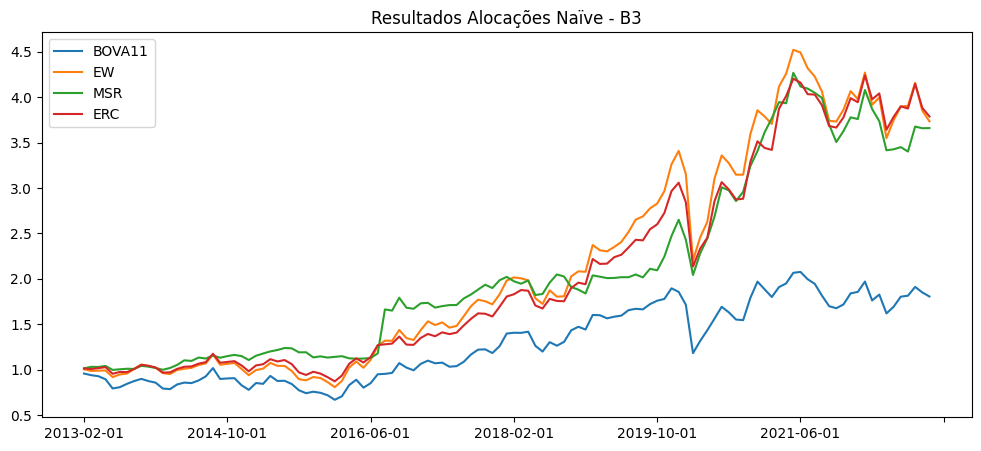

In [5]:
periodos = 36
oos = 1

bova = f.returns(benchmark);print('Benchmark Done')
rets_ew = f.pipeline(stock_prices, periodos, oos, algo=f.weight_ew);print('EW Done')
rets_msr = f.pipeline(stock_prices, periodos, oos, algo=f.msr_weights);print('MSR Done')
rets_erc = f.pipeline(stock_prices, periodos, oos, algo=f.weight_erc);print('ERC Done')

naive_portfolios_results = pd.DataFrame(
    {
    "BOVA11": bova[rets_ew.index.min():],
     "EW": rets_ew['rets'], 
     "MSR": rets_msr['rets'], 
     "ERC": rets_erc['rets'],
    }
)

(1+naive_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naïve - B3");
f.summary_stats(naive_portfolios_results, .03)

In [6]:
naive_portfolios_results.corr()

,BOVA11,EW,MSR,ERC
BOVA11,1.000000,0.945133,0.504070,0.929542
EW,0.945133,1.000000,0.569692,0.982434
MSR,0.504070,0.569692,1.000000,0.557600
ERC,0.929542,0.982434,0.557600,1.000000
